In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
sns.set_style('darkgrid')

In [3]:
from google.cloud import bigquery

In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\idmak\Documents\University_projects\service-account-file.json"

In [5]:
client = bigquery.Client()

In [7]:
ds_ref = client.dataset('chicago_crime', project='bigquery-public-data')
ds = client.get_dataset(ds_ref)

In [9]:
table_ref = ds_ref.table("crime")
crime = client.get_table(table_ref)

In [100]:
df = client.list_rows(crime,max_results=10000).to_dataframe()
df.columns

Index(['unique_key', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [101]:
df.isna().sum()

unique_key                0
case_number               0
date                      0
block                     0
iucr                      0
primary_type              0
description               0
location_description     11
arrest                    0
domestic                  0
beat                      0
district                  0
ward                      0
community_area            0
fbi_code                  0
x_coordinate            137
y_coordinate            137
year                      0
updated_on                0
latitude                137
longitude               137
location                137
dtype: int64

In [102]:
df.shape

(10000, 22)

In [105]:
df = df.dropna()
df.shape

(9855, 22)

In [189]:
df.primary_type.unique()

array(['DECEPTIVE PRACTICE', 'NARCOTICS', 'PUBLIC PEACE VIOLATION',
       'BURGLARY', 'OTHER OFFENSE', 'LIQUOR LAW VIOLATION', 'THEFT',
       'BATTERY', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'OFFENSE INVOLVING CHILDREN', 'CRIMINAL DAMAGE', 'ASSAULT',
       'KIDNAPPING', 'SEX OFFENSE', 'WEAPONS VIOLATION', 'OBSCENITY',
       'HUMAN TRAFFICKING', 'HOMICIDE', 'CRIM SEXUAL ASSAULT', 'ARSON',
       'INTIMIDATION', 'STALKING', 'GAMBLING', 'PROSTITUTION',
       'CRIMINAL SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER',
       'NON - CRIMINAL', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'OTHER NARCOTIC VIOLATION'], dtype=object)

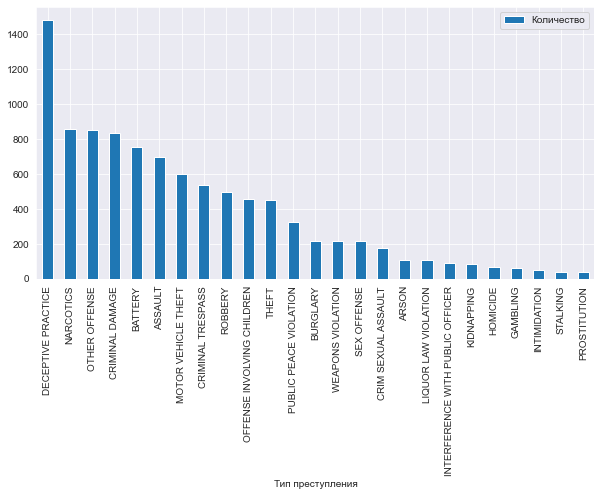

In [197]:
crime_type_count = df[['unique_key',"primary_type"]].groupby('primary_type',as_index=False).count() \
                                                    .rename(columns={'unique_key': 'count'})

crime_type_count.sort_values(by="count",ascending=False).head(25) \
                .plot.bar(figsize=(10,5),rot=90,y="count",x="primary_type");
plt.legend(labels=["Количество"])
plt.xlabel("Тип преступления")
plt.savefig("ch-type-count-bar")

In [195]:
crime_type_count.sort_values(by="count",ascending=False).reset_index(drop=True).head(10)

,primary_type,count
0,DECEPTIVE PRACTICE,1483
1,NARCOTICS,857
2,OTHER OFFENSE,854
3,CRIMINAL DAMAGE,835
4,BATTERY,753
5,ASSAULT,698
6,MOTOR VEHICLE THEFT,602
7,CRIMINAL TRESPASS,535
8,ROBBERY,499
9,OFFENSE INVOLVING CHILDREN,456


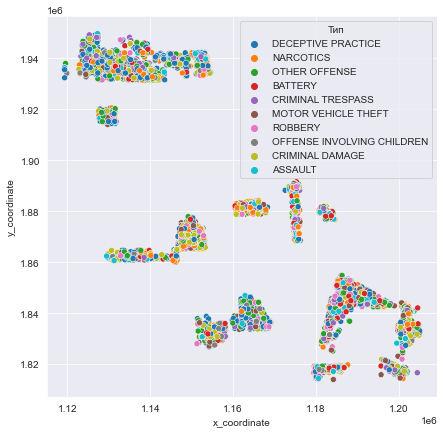

In [200]:
top_crime_types = crime_type_count.sort_values(by="count",ascending=False).primary_type.head(10).tolist()

plt.figure(figsize=(7,7))
long_lat_graph = sns.scatterplot(data=df.query('primary_type in @top_crime_types & latitude>37'),
                         x='x_coordinate',y='y_coordinate',hue='primary_type')
plt.legend(title="Тип")
plt.savefig("ch-geo-type")

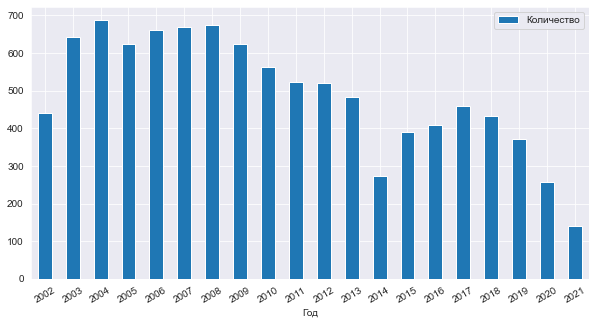

In [202]:
crime_by_year = df[['unique_key','year']].groupby('year',as_index=False).count() \
                                        .rename(columns={'unique_key':'count'}).sort_values(by='year')

crime_by_year[crime_by_year.year > 2001].plot.bar(y="count",x="year",figsize=(10,5),rot=30);
plt.legend(labels=["Количество"])
plt.xlabel("Год")
plt.savefig("ch-year-count")